# Genetic Algorithm Assignment

## The Problem         **(~30%)**

<h4>Description of the problem</h4>





This assignment involves working with a dataset of used cars and applying a genetic algorithm to develop a formula that predicts the price of a used car based on various attributes. These attributes include both categorical and numerical properties of the car, such as its condition, manufacturer, cylinder, fuel type, transmission, drive type, size, model type, state, odometer reading, and year of manufacture.

It is assumed that the formula for predicting the used car price can be expressed as a weighted sum of these attributes. Specifically, the equation is structured as follows:

    F(used_car_price) = manufacturer * manufacturer_gene + year * year_gene + odometer * odometer_gene ...

The objective is to use the genetic algorithm to optimize the weights for each property and derive an accurate predictive model for the car prices.

<br><h4>Discussion of the suitablity of Genetic Algorithms</h4>


Genetic Algorithms (GAs) can be a suitable tool for estimating used car prices because they are capable of optimizing complex, non-linear relationships between input features and output values. By evolving weights for features - including numeric and one-hot encoded categorical variables - GAs can effectively discover which factors have the most influence on car prices, even without assuming any specific mathematical relationship. Their flexibility and global search capabilities make them especially useful in high-dimensional problems where traditional models might struggle.

However, the performance of a GA heavily depends on the design of its fitness (cost) function. If the cost function poorly reflects real-world pricing logic, the algorithm can converge on solutions that are mathematically optimal but practically meaningless. Additionally, GAs can be computationally intensive and offer limited interpretability compared to more traditional models. While GAs offer a creative way to evolve a pricing formula, their effectiveness is ultimately constrained by the quality of the objective they are optimizing.

As mentioned above, this project assumes that the price of a used car can be represented as a weighted sum of its features. However, in reality, the relationship between car attributes and price is often much more complex. For example, odometer readings affect different car models in different ways—some engines are built to last much longer than others—so subtracting a fixed value based on mileage across all cars may not reflect true market behavior. Similar issues arise with other features like fuel type, drivetrain, or size, where their influence on price might be non-linear or depend on combinations of features.

Despite these limitations, a Genetic Algorithm can still offer useful insights. Even if the final formula isn't perfectly accurate for every individual car, the algorithm tends to evolve a set of weights that represent an average influence of each feature on price. In this way, it helps identify general trends—such as how odometer, fuel type, or size typically impact a vehicle's value—and allows for rough price estimation based on those trends

 <br><h4>Complexity of the problem  </h4>

To develop a robust Genetic Algorithm for predicting used car prices, several key steps were necessary to handle the complexity of the data and the optimization process:

<i>Dataset Selection and Cleaning</i>: The first step was to find a dataset rich in relevant car properties. This was critical because missing an important feature - such as year, fuel type, or manufacturer - could result in completely inaccurate price predictions. Data cleaning was equally important, as the dataset included many null values and unrealistic entries, such as 100-year-old vehicles or cars with a price of zero. These outliers needed to be removed to ensure a reliable training set.

<i>One-Hot Encoding for Categorical Features</i>: The dataset contained both numerical and categorical values. Numerical features like odometer or year could be directly used in the cost function. However, categorical features (e.g., fuel type, manufacturer, drive) required a more thoughtful approach. Replacing these with ordered numbers (e.g., gas = 1, electric = 4) would incorrectly imply a linear relationship. Instead, one-hot encoding was used to assign individual weights to each category, allowing the Genetic Algorithm to evolve specific impacts for each value. For example, if a car uses gas, only the gene associated with “gas” would contribute to the final price. While this method doesn't account for interactions between features, it provides a more accurate and flexible representation than simple numerical encoding.

<i>Individual Design</i>: Each individual in the population represents a potential pricing formula, composed of both numerical and categorical gene weights. Since some properties (like year or odometer) naturally decrease the value of a car, the design assumed that these features reduce the total cost. To manage this, individuals were structured as an array containing two dictionaries: one for numeric features and one for categorical features. For numeric properties, each key holds a single weight value, while categorical features store arrays of weights—one for each unique category (e.g., fuel types). This structure makes it easier to manage crossover and mutation operations by clearly separating feature types and allowing fine-grained control over how each gene is modified or inherited.

<i>Mutation</i>: Mutation was implemented using the cost function to guide adjustments in gene values. This allowed for controlled changes aimed at improving overall fitness rather than applying random alterations. While not particularly complex, this step required careful logic to ensure that mutations led to meaningful improvements rather than degrading the solution.

<i>Crossover</i>: The crossover function was designed to generate two children from two parents using different strategies. In both cases, genes from the fitter parent were combined with those of the less fit parent to create new individuals. Since the car price is determined by the combination of gene weights, this method increases the chance of producing better offspring over time. However, due to the problem's complexity and high dimensionality, many generations may still be required to reach a near-optimal solution

In [36]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#This code should be run only if an original vehicles.csv file is used.
#It can be found in the kaggle datasets using this link (the file was too heave for github.com):
#https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data
#Otherwise this cell should be skipped, the next one can be run
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import random
used_cars = pd.read_csv('vehicles.csv')

#removing unnecessary columns from the dataset
used_cars.drop('id', axis=1, inplace=True)
used_cars.drop('url', axis=1, inplace=True)
used_cars.drop('region_url', axis=1, inplace=True)
used_cars.drop('paint_color', axis=1, inplace=True)
used_cars.drop('lat', axis=1, inplace=True)
used_cars.drop('posting_date', axis=1, inplace=True)
used_cars.drop('long', axis=1, inplace=True)
used_cars.drop('image_url', axis=1, inplace=True)
used_cars.drop('title_status', axis=1, inplace=True)
used_cars.drop('VIN', axis=1, inplace=True)
used_cars.drop('description', axis=1, inplace=True)
used_cars.drop('county', axis=1, inplace=True)
used_cars.drop('model', axis=1, inplace=True)
used_cars.drop('region', axis=1, inplace=True)

#dropping all null values from important columns
used_cars.dropna(subset = ['price', 'year', 'manufacturer', 'cylinders',
                           'fuel', 'odometer', 'transmission', 'drive', 'size',
                          'type', 'state', 'condition'], inplace=True)

used_cars = used_cars.loc[used_cars['fuel'] != 'other']
used_cars = used_cars.loc[used_cars['cylinders'] != 'other']
used_cars = used_cars.loc[used_cars['transmission'] != 'other']
used_cars = used_cars.loc[used_cars['type'] != 'other']

# Remove unrealistic years
used_cars = used_cars[(used_cars['year'] >= 1990) & (used_cars['year'] <= 2025)]

#Remove unrealistic prices
used_cars = used_cars[(used_cars['price'] > 500) & (used_cars['price'] < 50000)]  # Reasonable car prices

#Remove unrealistic values
used_cars = used_cars[(used_cars['odometer'] > 1000) & (used_cars['odometer'] < 1000000)] 

#function for transforming 
def get_indexes(column):
    items = {}
    count = 1
    for item in used_cars[column].unique():
        items[item] = count
        count=count+1
    return items

# Although the one-hot encoded values may look like simple numeric replacements, they are actually
# placeholders for weights. Each unique categorical value is always assigned to the same index in
# the encoded array— for example, "gas" might always appear at index 0, "diesel" at index 1, and so on.
# Later in the algorithm, these indexes are not treated as actual values but are instead linked to
# evolving weights that represent the influence of each category on the final price. This consistent
# indexing allows for easy replacement with weights during evaluation, and the original string values
# can still be retrieved using these mapping variables if needed
condition_mapping = {'salvage': 1, 'new': 6, 'like new': 4,'good' : 3, 'fair' : 2, 'excellent': 5}
manufacturer_mapping = get_indexes('manufacturer')
cylinders_mapping = get_indexes('cylinders')
fuel_mapping = {'gas': 1, 'diesel': 2, 'hybrid': 3, 'electric': 4}
transmission_mapping = {'automatic': 1, 'manual': 2}
drive_mapping = {'rwd': 1, '4wd': 2, 'fwd': 3}
size_mapping = {'full-size': 1, 'mid-size': 2, 'compact': 3, 'sub-compact': 4}
type_mapping = get_indexes('type')
state_mapping = get_indexes('state')

#transforming year into age. if a car was created in 2012, the age will be 2025-2012=13 years old
used_cars['age'] = used_cars['year'].apply(lambda x: 2025 - x)
used_cars.drop('year', axis=1, inplace=True)

#implementing one-hot encoding
used_cars['condition'] = used_cars['condition'].replace(condition_mapping)
used_cars['manufacturer'] = used_cars['manufacturer'].replace(manufacturer_mapping)
used_cars['cylinders'] = used_cars['cylinders'].replace(cylinders_mapping)
used_cars['fuel'] = used_cars['fuel'].replace(fuel_mapping)
used_cars['transmission'] = used_cars['transmission'].replace(transmission_mapping)
used_cars['drive'] = used_cars['drive'].replace(drive_mapping)
used_cars['size'] = used_cars['size'].replace(size_mapping)
used_cars['type'] = used_cars['type'].replace(type_mapping)
used_cars['state'] = used_cars['state'].replace(state_mapping)

#function to get genes structure
def get_genes():
    genes = [{}, {}]
    for column in used_cars.columns:
        if column == 'age' or column == 'price' or column == 'odometer' or column == 'condition':
            continue
        genes[0][column] = [1000 for value in range(0, used_cars[column].value_counts().count())]
    genes[1]['age'] = -50
    genes[1]['odometer'] = -5/1000
    genes[1]['condition'] = 200
    return genes

In [38]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#This code should be run only if the vehicles file that came with this file from github is used
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import random
used_cars = pd.read_csv('cleaned_vehicles.csv')

#function for transforming 
def get_indexes(column):
    items = {}
    count = 1
    for item in used_cars[column].unique():
        items[item] = count
        count=count+1
    return items

# Although the one-hot encoded values may look like simple numeric replacements, they are actually
# placeholders for weights. Each unique categorical value is always assigned to the same index in
# the encoded array— for example, "gas" might always appear at index 0, "diesel" at index 1, and so on.
# Later in the algorithm, these indexes are not treated as actual values but are instead linked to
# evolving weights that represent the influence of each category on the final price. This consistent
# indexing allows for easy replacement with weights during evaluation, and the original string values
# can still be retrieved using these mapping variables if needed
condition_mapping = {'salvage': 1, 'new': 6, 'like new': 4,'good' : 3, 'fair' : 2, 'excellent': 5}
manufacturer_mapping = get_indexes('manufacturer')
cylinders_mapping = get_indexes('cylinders')
fuel_mapping = {'gas': 1, 'diesel': 2, 'hybrid': 3, 'electric': 4}
transmission_mapping = {'automatic': 1, 'manual': 2}
drive_mapping = {'rwd': 1, '4wd': 2, 'fwd': 3}
size_mapping = {'full-size': 1, 'mid-size': 2, 'compact': 3, 'sub-compact': 4}
type_mapping = get_indexes('type')
state_mapping = get_indexes('state')

#implementing one-hot encoding
used_cars['condition'] = used_cars['condition'].replace(condition_mapping)
used_cars['manufacturer'] = used_cars['manufacturer'].replace(manufacturer_mapping)
used_cars['cylinders'] = used_cars['cylinders'].replace(cylinders_mapping)
used_cars['fuel'] = used_cars['fuel'].replace(fuel_mapping)
used_cars['transmission'] = used_cars['transmission'].replace(transmission_mapping)
used_cars['drive'] = used_cars['drive'].replace(drive_mapping)
used_cars['size'] = used_cars['size'].replace(size_mapping)
used_cars['type'] = used_cars['type'].replace(type_mapping)
used_cars['state'] = used_cars['state'].replace(state_mapping)

#function to get genes structure
def get_genes():
    genes = [{}, {}]
    for column in used_cars.columns:
        if column == 'age' or column == 'price' or column == 'odometer' or column == 'condition':
            continue
        genes[0][column] = [1000 for value in range(0, used_cars[column].value_counts().count())]
    genes[1]['age'] = -50
    genes[1]['odometer'] = -5/1000
    genes[1]['condition'] = 200
    return genes

# The problem and the cost function   **(~20%)**

In [25]:
#cost function for calculating a price of a used car
def cost_func(genes):
    pos_sum = 0
    pos_count = 0
    neg_sum = 0
    for index, used_car in used_cars.iterrows():
        str_sum = 0
        #calculating the sum of categorical values
        for gene in genes[0]:
            str_sum = str_sum + genes[0][gene][int(used_car[gene] - 1)]
        
        #calculating the sum of numerical values
        int_sum = genes[1]['age'] * used_car['age'] + genes[1]['odometer'] * used_car['odometer'] + genes[1]['condition'] * used_car['condition']
        
        #finding the total sum
        total_diff = str_sum + int_sum - used_car['price']
        if total_diff > 0:
            pos_sum = pos_sum + total_diff
            pos_count = pos_count + 1
        if total_diff <= 0:
            neg_sum = neg_sum + total_diff
        #returing average positive sum and average negative sum for better mutation and crossover managing
    return (pos_sum/pos_count, neg_sum / (len(used_cars) - pos_count))


class problem:
    def __init__(self):
        self.age_range = (-500, -50)
        self.odometer_range = (-50/10000, -1000/10000)
        self.manufacturer_range = (-1000, 20000)
        self.condition_range = (0, 500)
        self.cylinders_range = (100, 1000)
        self.fuel_range = (0, 1000)
        self.transmission_range = (0, 5000)
        self.drive_range = (0, 2000)
        self.size_range = (0, 2000)
        self.type_range = (0, 5000)
        self.state_range = (-1000, 1000)
        
        self.cost_function = cost_func
        
    def get_all_genes(self):
        genes = [{}, {}]
        genes[0]['manufacturer'] = [np.random.uniform(self.manufacturer_range[0], self.manufacturer_range[1]) for value in range(0, used_cars['manufacturer'].value_counts().count())]
        genes[1]['age'] = np.random.uniform(self.age_range[0], self.age_range[1])
        genes[1]['odometer'] = np.random.uniform(self.odometer_range[0], self.odometer_range[1])
        genes[1]['condition'] = np.random.uniform(self.condition_range[0], self.condition_range[1])
        genes[0]['cylinders'] = [np.random.uniform(self.cylinders_range[0], self.cylinders_range[1]) for value in range(0, used_cars['cylinders'].value_counts().count())]
        genes[0]['fuel'] = [np.random.uniform(self.fuel_range[0], self.fuel_range[1]) for value in range(0, used_cars['fuel'].value_counts().count())]
        genes[0]['transmission'] = [np.random.uniform(self.transmission_range[0], self.transmission_range[1]) for value in range(0, used_cars['transmission'].value_counts().count())]
        genes[0]['drive'] = [np.random.uniform(self.drive_range[0], self.drive_range[1]) for value in range(0, used_cars['drive'].value_counts().count())]
        genes[0]['size'] = [np.random.uniform(self.size_range[0], self.size_range[1]) for value in range(0, used_cars['size'].value_counts().count())]
        genes[0]['type'] = [np.random.uniform(self.type_range[0], self.type_range[1]) for value in range(0, used_cars['type'].value_counts().count())]
        genes[0]['state'] = [np.random.uniform(self.state_range[0], self.state_range[1]) for value in range(0, used_cars['state'].value_counts().count())]
        return genes

# The Individual **(~30%)**

In [3]:
class individual:
    def __init__(self,prob):
        self.chromosome = prob.get_all_genes()
        self.cost = prob.cost_function(self.chromosome)

    def get_cost(self):
        return self.cost[0] + abs(self.cost[1])

    
    def mutate(self, rate_of_gene_mutation, range_of_gene_mutation):
        if self.cost[0] > abs(self.cost[1]):
            range_of_gene_mutation = - (range_of_gene_mutation + np.random.uniform(-0.1, 0.1)) 
        for gene_index in range(3):
            if  np.random.uniform() < rate_of_gene_mutation:
                key = list(self.chromosome[1].keys())[gene_index]
                self.chromosome[1][key] = self.chromosome[1][key] + self.chromosome[1][key] * range_of_gene_mutation
        for gene_index in range(len(self.chromosome[0])):
            key = list(self.chromosome[0].keys())[gene_index]
            for index in range(0, len(self.chromosome[0][key])):
                if np.random.uniform() < rate_of_gene_mutation:
                    self.chromosome[0][key][index] += self.chromosome[0][key][index] * range_of_gene_mutation
                    
        
    def crossover(self, parent2, explore_crossover):
        is_parent2_avg_neg_greater = parent2.cost[1] < self.cost[1]
        is_parent2_avg_pos_greater = parent2.cost[0] > self.cost[0]

        loser_genes_rate = 0.5 - explore_crossover / 2
        winner_genes_rate = 1 - loser_genes_rate

        #generating the first child
        child1 = deepcopy(self)    
        if not is_parent2_avg_neg_greater:
            winner_genes_rate = 0.5 - explore_crossover / 2
            loser_genes_rate = 1 - winner_genes_rate

        child1.chromosome[1]['age'] = self.chromosome[1]['age'] * winner_genes_rate + parent2.chromosome[1]['age'] * loser_genes_rate
        child1.chromosome[1]['odometer'] = self.chromosome[1]['odometer'] * winner_genes_rate + parent2.chromosome[1]['odometer'] * loser_genes_rate

        if not is_parent2_avg_pos_greater:
            winner_genes_rate = 0.5 - explore_crossover / 2
            loser_genes_rate = 1 - winner_genes_rate
        else:
            loser_genes_rate = 0.5 - explore_crossover / 2
            winner_genes_rate = 1 - loser_genes_rate

        child1.chromosome[1]['condition'] = self.chromosome[1]['condition'] * winner_genes_rate + parent2.chromosome[1]['condition'] * loser_genes_rate
        for key in list(self.chromosome[0].keys()):
            for i in range(0, len(child1.chromosome[0][key])):
                child1.chromosome[0][key][i] = self.chromosome[0][key][i] * winner_genes_rate + parent2.chromosome[0][key][i] * loser_genes_rate     

        #generating the second child
        child2 = deepcopy(parent2)
        num_genes = len(self.chromosome[1])
        p1_genes_num = random.randint(round(explore_crossover * num_genes), num_genes)
        p1_genes = random.sample(range(0, num_genes), p1_genes_num)
        for i in p1_genes:
            key = list(self.chromosome[1].keys())[i]
            child2.chromosome[1][key] = self.chromosome[1][key]

        for gene_index in range(len(child2.chromosome[0])):
            key = list(child2.chromosome[0].keys())[gene_index]
            num_genes = len(self.chromosome[0][key])
            p1_genes_num = random.randint(round(explore_crossover * num_genes), num_genes)
            p1_genes = random.sample(range(0, num_genes), p1_genes_num)
            for index in p1_genes:
                child2.chromosome[0][key][index] = self.chromosome[0][key][index]
        return child1,child2

## Discussion and justification on the approaches taken for the above

<h3>Chromosome</h3>

As can be seen from the code each chromosome has the next genes in these ranges:
1. Numeric values:
    - Age: values range from -500 to -50
    - Odometer: values range from -0.005 to -0.1
    - Condition: values range from 0 to 500
2. Categorical values:
    - Manufacturer: values range from -1000 to 20,000
    - Cylinders: values range from 100 to 1,000
    - Fuel type: values range from 0 to 1,000
    - Transmission: values range from 0 to 5,000
    - Drive type: values range from 0 to 2,000
    - Size: values range from 0 to 2,000
    - Car type (e.g., SUV, sedan): values range from 0 to 5,000
    - State (location): values range from -1,000 to 1,000
    
  Some genes in the chromosome were assigned fully or partially negative value ranges based on assumptions about their typical influence on a car's price: <br> <br>
   Age and Odometer: As mentioned earlier, it is assumed that the older a car is and the more it has been used, the lower its value tends to be. Therefore, both features were assigned negative ranges. The odometer range is relatively small because the raw values in the dataset span a wide range—from around 10,000 to over 10 million—whereas car prices are generally much smaller. Scaling the odometer values ensures that they contribute proportionally to the total cost. <br> <br>
   Manufacturer and State: These features were also allowed to have negative weights. While not all manufacturers or locations reduce a car’s price, the assumption is that some combinations—such as a specific brand paired with high mileage or certain drivetrain types—may lower the vehicle's overall value. Similarly, the state where the car is sold might influence price due to external factors such as crime rate, infrastructure quality, or local market demand. Although the cost function must generalize across all data, allowing negative weights here helps better fit regional and brand-specific pricing trends. <br> <br>
   Additionally, the condition feature, while originally categorical, was treated as numerical. This decision was based on the assumption that sellers tend to slightly overstate a car’s condition, making it less reliable as a strong price indicator. To include it in the cost function effectively, condition categories were assigned decreasing numeric values starting from “new” (highest) down to “salvage” (lowest), under the assumption that only new or near-new conditions significantly impact price. However, this approach is imperfect, as there are cases where a new vehicle may be less valuable than a well-maintained used one, or where the reported condition doesn’t reflect reality. <br> <br>
   Other features, such as transmission type, fuel, drive, and car size, were assigned positive ranges, but this does not mean their weights must always remain positive. Both crossover and mutation functions are designed to explore the full range of possible weights—positive or negative—to discover the best combination that minimizes prediction error and finds the optimal solution

<h3>Crossover</h3>

<h6>The first child generating algorithm</h6>
The crossover function generates two children using different strategies. The first child is created by combining genes from both parents based on their performance (cost). Specifically, a weighted average of each gene is calculated, where the weights are determined by how well each parent performed—i.e., how "fit" they are based on the cost function.
For example, consider a gene like age: if Parent 1 has a value of -300 and a better (lower) cost of -3000, while Parent 2 has a value of -200 with a cost of -5000, the algorithm will favor Parent 1 more. Assuming a calculated crossover rate results in a 70/30 weighting, the child’s age gene would be:
-300 * 0.7 + -200 * 0.3 = -270
This approach is applied across all numeric genes, whether they are positive (e.g., condition or manufacturer) or negative (e.g., odometer or age).
The weighting ratio is determined by the crossover rate, which is calculated based on the difference between the better and worse parent. The child receives a higher proportion of genes from the fitter parent to increase the chances of passing down beneficial traits. For example, if Parent 1 has better performance for negative cost components (like mileage or age), the child will inherit a larger portion of those specific genes from Parent 1. Conversely, if Parent 2 performs better in positive cost components (like condition or manufacturer), those genes will be more heavily weighted in favor of Parent 2. 
This targeted blending strategy is designed to minimize total cost by leveraging each parent’s strongest traits and guiding the algorithm toward better solutions over time. By prioritizing gene inheritance based on individual strengths, the algorithm avoids random mixing and instead promotes gradual improvement across generations. This approach not only accelerates convergence but also increases the likelihood of finding a well-balanced and generalizable solution

<h6>The second child generating algorithm</h6>
The second child is generated using a gene selection method that takes complete genes from either parent without modification. Unlike the first child, which blends values, this approach selects entire gene values directly—e.g., taking age, manufacturer, fuel, and size from Parent 1, while the remaining genes (e.g., odometer, condition, drive) are taken from Parent 2. This method aims to explore combinations of already optimized genes rather than averaging them, allowing the algorithm to preserve strong traits exactly as they appear in each parent.
For instance, if Parent 1 has a manufacturer weight that is incorrectly negative, while Parent 2 has a more appropriate positive value, and if Parent 1 also has a correct negative value for a different feature (e.g., state), the child may end up with both optimal values: the positive manufacturer weight from Parent 2 and the correct negative state value from Parent 1. While not guaranteed to always reduce the cost—since some combinations may unintentionally worsen performance—this strategy increases genetic diversity and helps the algorithm discover more effective feature groupings over time. This technique supports broader exploration of the solution space, improving the chance of finding high-quality individuals across generations.
Detailed description of how this algorithm works is displayer below:
<br>Parent1   Parent2   Child
<br> 12         47      47
<br> 33         88      33
<br> 75         19      75
<br> 61         61      61
<br>  8         90      8
<br> 44         11      11
<br> 29         73      73
<br> 50         36      36
<br> 97         20      97
<br> 45         66      45




<h3>Mutation</h3>

The mutation algorithm is relatively straightforward. It iterates through each gene and, for every gene, generates a random number between 0 and 1. If this number exceeds a predefined mutation rate, the gene is selected for mutation. The direction of mutation is guided by the individual's current cost: if the negative component of the cost is greater, the algorithm attempts to decrease negatively weighted genes and increase positively weighted ones. Conversely, if the positive cost dominates, it increases negative genes and reduces positive ones.

This targeted adjustment strategy allows the algorithm to focus on correcting the most costly components of the individual, rather than introducing entirely random noise. In testing, this method has consistently shown to improve the overall fitness of individuals, helping the genetic algorithm converge more efficiently toward better solutions.

## Running the algorithm  **(~10%)**

*   Parameter choices
*   Modifications (if any) to run_genetic
*   Rationale for the above



In [11]:
class parameters:
    def __init__(self):
        self.population  = 8
        self.number_of_generations = 50
        self.child_rate_per_generation = 1
        self.crossover_explore_rate = 0.3
        self.gene_mutate_range = 0.2
        self.gene_mutate_rate = 0.3

As seen in the parameter settings, both the population size and number of generations were significantly reduced, and this decision was driven by several practical considerations:
- The algorithm is computationally expensive. With over 70,000 rows in the dataset, generating 1,000 individuals takes more than 10 minutes. Additionally, both the crossover and mutation functions require individuals to have an up-to-date and valid cost value. If this cost is outdated, operations can yield incorrect results, meaning frequent re-evaluation adds substantial processing time—potentially multiplying total runtime by four or more.
- The mutation and crossover functions were intentionally designed to iteratively improve the same individuals across multiple generations. This makes the algorithm more effective when working with fewer individuals over more generations, rather than a large, diverse population in each cycle. A larger population increases the chance of skipping over promising individuals before they can be refined, whereas a smaller, consistent population allows repeated improvement and convergence toward better solutions.

In [12]:
def choose_indices_from(length):
    index1 = random.randint(0, length - 1)
    index2 = random.randint(0, length - 1)
    if index1 == index2:
        return choose_indices_from(length)
    return (index1, index2)

One important modification made to the run_genetic function was the addition of a cost update after each mutation. Specifically, once an individual undergoes mutation, its cost is immediately recalculated by calling the cost function. This adjustment is essential because, as mentioned earlier, both the mutation and crossover operations rely on accurate and up-to-date cost values to make informed decisions. Without this step, subsequent operations could use outdated fitness scores, leading to incorrect gene adjustments and suboptimal offspring generation

In [13]:
def run_genetic(prob, params):
    cost_function = prob.cost_function

    number_in_population = params.population
    max_number_of_generations = params.number_of_generations
    number_of_children_per_generation = params.child_rate_per_generation * number_in_population
    explore_crossover = params.crossover_explore_rate
    gene_mutate_rate = params.gene_mutate_rate
    gene_mutate_range = params.gene_mutate_range

    population = []

    best_solution = individual(prob)
    best_solution.cost = (np.infty, np.infty)
    for i in range(number_in_population):
        new_individual = individual(prob)
        population.append(new_individual)
        if new_individual.get_cost() < best_solution.get_cost():
            best_solution = deepcopy(new_individual)
    print("First " + str(number_in_population) + " individuals are ready")
    for _iteration in range(max_number_of_generations):
        children = []
        while len(children) < number_of_children_per_generation:
            parent1_index , parent2_index = choose_indices_from(len(population))
            parent1 = population[parent1_index]
            parent2 = population[parent2_index]       
            child1, child2 = parent1.crossover(parent2,explore_crossover)
            child1.cost = cost_function(child1.chromosome)
            child2.cost = cost_function(child2.chromosome)
            child1.mutate(gene_mutate_rate, gene_mutate_range)
            child1.cost = cost_function(child1.chromosome)
            child2.mutate(gene_mutate_rate, gene_mutate_range)
            child2.cost = cost_function(child2.chromosome)
            children.append(individual(prob))
            children.append(individual(prob))
        
        population+=children
        population = sorted(population, key = lambda x:x.get_cost())          
        population = population[:number_in_population]
        
        if population[0].get_cost() < best_solution.get_cost():
            best_solution = deepcopy(population[0])
        print("Best Solution for iteration " + str(_iteration) + " has cost of " + str(best_solution.get_cost()))
    return best_solution

In [14]:
params = parameters()
prob = problem()
best_solution = run_genetic(prob, params)

First 8 individuals are ready
Best Solution for iteration 0 has cost of 14267.00018562216
Best Solution for iteration 1 has cost of 14267.00018562216
Best Solution for iteration 2 has cost of 14267.00018562216
Best Solution for iteration 3 has cost of 14267.00018562216
Best Solution for iteration 4 has cost of 13808.943784728986
Best Solution for iteration 5 has cost of 13808.943784728986
Best Solution for iteration 6 has cost of 13808.943784728986
Best Solution for iteration 7 has cost of 13808.943784728986
Best Solution for iteration 8 has cost of 13808.943784728986
Best Solution for iteration 9 has cost of 13808.943784728986
Best Solution for iteration 10 has cost of 13808.943784728986
Best Solution for iteration 11 has cost of 13808.943784728986
Best Solution for iteration 12 has cost of 13808.943784728986
Best Solution for iteration 13 has cost of 13808.943784728986
Best Solution for iteration 14 has cost of 13808.943784728986
Best Solution for iteration 15 has cost of 13808.94378

In [15]:
best_solution.cost

(4811.091454172307, -8681.075448160122)

In [16]:
best_solution.chromosome

[{'manufacturer': [12780.473275209362,
   5419.683747004315,
   13400.858080932538,
   11403.835982738885,
   10783.897456511264,
   14894.395249484416,
   5958.721307473866,
   16914.912922210082,
   11602.730624677559,
   7836.490460612058,
   -44.41862619431856,
   14129.447044818047,
   17121.949797880683,
   12325.431667996301,
   15823.853198423967,
   4898.837156026521,
   9693.652827337655,
   672.0633885412444,
   17161.365321545145,
   16304.274507163234,
   8553.197650046082,
   19953.646015276547,
   12479.279196509891,
   6033.778683351913,
   7966.13008700321,
   17122.70301758327,
   19076.235908916096,
   4521.934407393283,
   4478.073525716891,
   17766.682955440167,
   1446.2144322863182,
   15497.516624963639,
   9434.415022435773,
   8797.795053911163,
   5660.421006169499,
   3102.4064413631822,
   10518.734694699338,
   9921.695646989057],
  'cylinders': [483.7384822173725,
   797.1008173558943,
   720.7332794058178,
   576.2627180122197,
   936.0752952108551,
   

In [111]:
best_solution.cost

(5739.185689658155, -7759.022254086618)

In [113]:
params = parameters()
prob = problem()
best_solution = run_genetic(prob, params)

First 8 individuals are ready
Best Solution for iteration 0 has cost of 14696.262029098465
Best Solution for iteration 1 has cost of 14696.262029098465
Best Solution for iteration 2 has cost of 14696.262029098465
Best Solution for iteration 3 has cost of 14075.065899904454
Best Solution for iteration 4 has cost of 14075.065899904454
Best Solution for iteration 5 has cost of 14075.065899904454
Best Solution for iteration 6 has cost of 14075.065899904454
Best Solution for iteration 7 has cost of 14075.065899904454
Best Solution for iteration 8 has cost of 14075.065899904454
Best Solution for iteration 9 has cost of 14075.065899904454
Best Solution for iteration 10 has cost of 14075.065899904454
Best Solution for iteration 11 has cost of 14075.065899904454
Best Solution for iteration 12 has cost of 14075.065899904454
Best Solution for iteration 13 has cost of 13586.56634464151
Best Solution for iteration 14 has cost of 13586.56634464151
Best Solution for iteration 15 has cost of 13586.566

In [114]:
best_solution.cost

(3895.0268527143976, -9295.712170530733)

## Results and conclusions    **(~10%)**

To demonstrate the working equation a price of all used cars were calculated using found equation:

In [33]:
#Calculating all cars prices using the Geneteric Algorithm equation and the difference with the actual price
used_car_prices_calculated = []
diff_car_prices = []
genes = best_solution.chromosome
for index, used_car in used_cars.iterrows():
    str_sum = 0
    for gene in genes[0]:
        str_sum = str_sum + genes[0][gene][int(used_car[gene] - 1)]
        
    int_sum = genes[1]['age'] * used_car['age'] + genes[1]['odometer'] * used_car['odometer'] + genes[1]['condition'] * used_car['condition']
        
    used_car_prices_calculated.append(str_sum + int_sum)
    diff_car_prices.append(used_car['price'] - str_sum + int_sum)

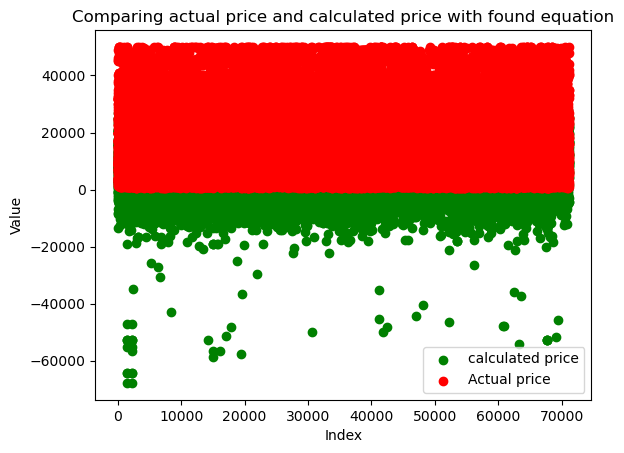

In [34]:
#Building a plot with actual values and predicted
plt.scatter(range(len(used_car_prices_calculated)), used_car_prices_calculated, color='green', label='calculated price')
plt.scatter(range(len(used_cars['price'])), used_cars['price'], color='red', label='Actual price')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Comparing actual price and calculated price with found equation')
plt.legend()
plt.show()

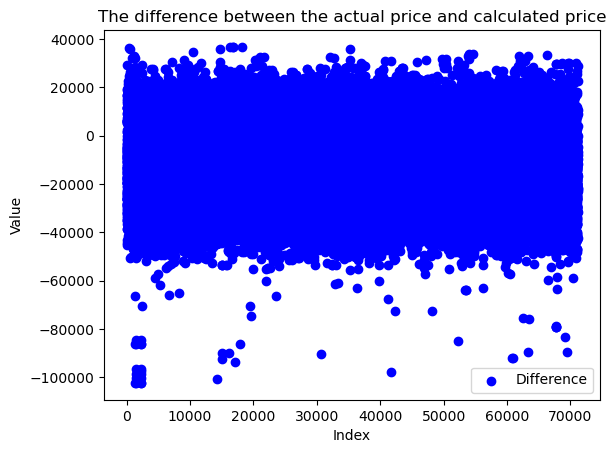

In [36]:
#Building a plot with diference between actual values and predicted
plt.scatter(range(len(diff_car_prices)), diff_car_prices, color='blue', label='Difference')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('The difference between the actual price and calculated price')
plt.legend()
plt.show()

In [52]:
print("Count of the used cars in which")
print("The difference between actual and calculated price is less than 100: " + str(len([num for num in diff_car_prices if num < 100 and num > -100])))
print("The difference actual and calculated price is less than 500: " + str(len([num for num in diff_car_prices if num < 500 and num > -500])))
print("The difference actual and calculated price is less than 1000: " + str(len([num for num in diff_car_prices if num < 1000 and num > -1000])))
print("The difference actual and calculated price is less than 10000: " + str(len([num for num in diff_car_prices if num < 10000 and num > -10000])))

Count of the used cars in which
The difference between actual and calculated price is less than 100: 127
The difference actual and calculated price is less than 500: 623
The difference actual and calculated price is less than 1000: 1289
The difference actual and calculated price is less than 10000: 14239


<h2>Result evaluation and conclusion</h2>

As seen in both graphs, the results are far from perfect. There are several possible reasons for this, starting with the most obvious: the equation used to model the problem is not well-suited for this type of task. All parameters were either added or subtracted from the total price, while some of them should have been multiplied instead.

For example, age was simply subtracted from the price, whereas in reality, car prices typically decrease by a percentage over time - and this rate can vary depending on the car type. In the results, the age gene ended up being -253, meaning that for every year of usage, the price of any car is reduced by 253 units. While this might make sense for lower-priced vehicles, it becomes unrealistic for more expensive cars. For instance, if a car originally costs100,000, a 10-year depreciation of only $2,530 is clearly inaccurate. This highlights a key flaw: the model assumes a flat linear decrease in price, rather than a percentage-based reduction, and fails to capture the real-world non-linear relationship between age and value. Although multiplication-based adjustments were also tested during this assignment, the results were quite similar to the basic approach. In both cases, the cost function remained linear and lacked the use of more advanced mathematical operations such as logarithms, roots, powers, or exponential decay — all of which could more accurately model such relationships

Another reason for the poor results could be the inclusion of irrelevant features or omission of important ones. For example, as mentioned earlier, the "condition" of a car doesn’t always affect its price accurately, since sellers tend to overstate it. The "state" parameter was also included in the equation, though it likely has very little actual impact on price - yet it was given significant weight. On the flip side, important properties like whether the car had been in an accident or how often it was maintained were missing from the dataset entirely. Such factors would have had a significant influence on price.

A further issue lies in the number of individuals and generations used in the evolutionary algorithm. The algorithm was designed to slightly mutate individuals after crossover to gradually reduce the total cost and improve the solution. However, even with 50 individuals and a target of 100 generations, the process ran for 11 hours and completed only around 30–40 generations. For this type of problem, ideally the algorithm would run for thousands of generations to allow for more gene swapping and mutations, which are crucial for improving the cost function.

Finally, a key assumption in the model may have led to inaccurate results: the idea that certain parameters should always increase or decrease the price. For example, "condition" was always treated as a positive influence — but in reality, labels like "salvage" or even "good" condition can significantly lower a car’s value. Similarly, the number of cylinders was assumed to increase value, while in practice, it can reduce a car’s desirability due to higher fuel consumption. These oversimplifications ignored the fact that the effect of one parameter can depend heavily on others, which led to a less accurate cost function